In [18]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import dask.array as da
import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20190515',
 'Aghulas_20191110',
 'Aghulas_20200121',
 'Aghulas_20200203',
 'Aghulas_20200215',
 'Aghulas_20200227',
 'Aghulas_20200309',
 'Aghulas_20200310',
 'Aghulas_20200321',
 'Aghulas_20200322',
 'Aghulas_20200402',
 'Aghulas_20200403',
 'Aghulas_20200414',
 'Aghulas_20200415',
 'Aghulas_20200426',
 'Aghulas_20200427',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Brasilia_20200402',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Morroco_20201022',
 'Morroco_20201103',
 'Morroco_20201115',
 'Scotland_20231109']

In [3]:
scenario = 'Aghulas_20200427'# 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=150,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:394: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# # test.wdir_wrt_sensor = 0
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200427/02F0_278B_ABCD_EC97_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200427h1700_lat-31_3_lon31_1.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

In [6]:
data_4subscene = ['doppler_pulse_rg', 'V_leakage_pulse_rg', 'V_sigma', 'nrcs_scat']
data_subscene = [name + '_subscene' for name in data_4subscene]
t = low_pass_filter_2D_dataset(test.data[data_4subscene], cutoff_frequency = 1/25_000, fill_nans=True, rechunk=True)
# test.data[data_subscene] = t

/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

In [47]:
convolutions = (test.data.V_leakage_pulse_rg - test.data.V_leakage_pulse_rg_inverted).rolling(grg=test.grg_N, slow_time=test.slow_time_N, center=True).mean()
fourier = low_pass_filter_2D(test.data.V_leakage_pulse_rg - test.data.V_leakage_pulse_rg_inverted, 
                             cutoff_frequency= 1/(1.5*test.resolution_product),
                             fill_nans = True,
                             rechunk = True)#.plot()

/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


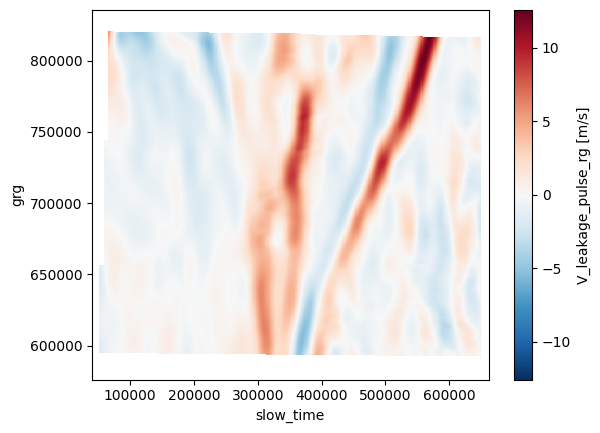

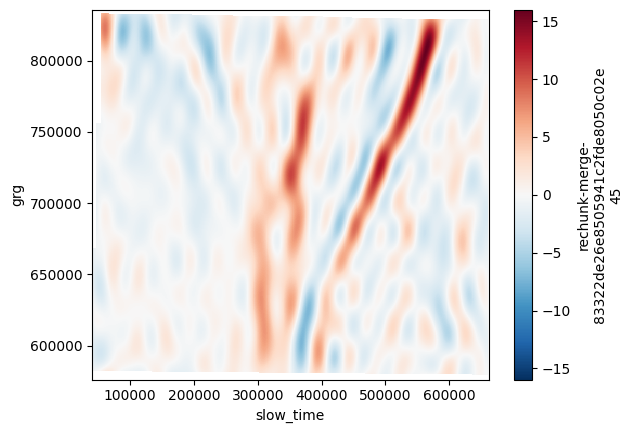

In [48]:
plt.figure()
convolutions.plot()
plt.figure()
fourier.plot()

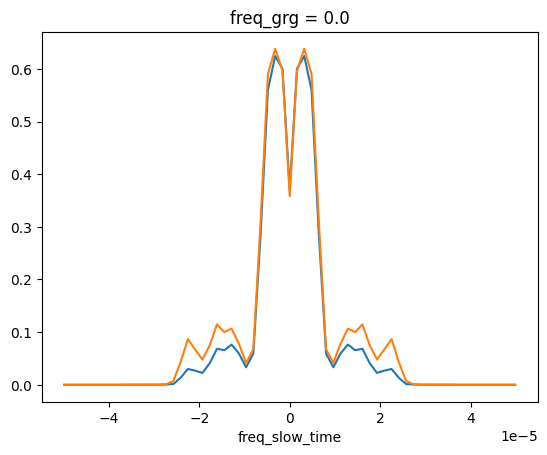

In [49]:
p1 = power_spectrum_custom(convolutions.chunk({**convolutions.sizes}))
p2 = power_spectrum_custom(fourier)

p1.sel(freq_grg = 0, method = 'nearest').sel(freq_slow_time = slice(-0.00005, 0.00005)).plot()
p2.sel(freq_grg = 0, method = 'nearest').sel(freq_slow_time = slice(-0.00005, 0.00005)).plot()

## Misc

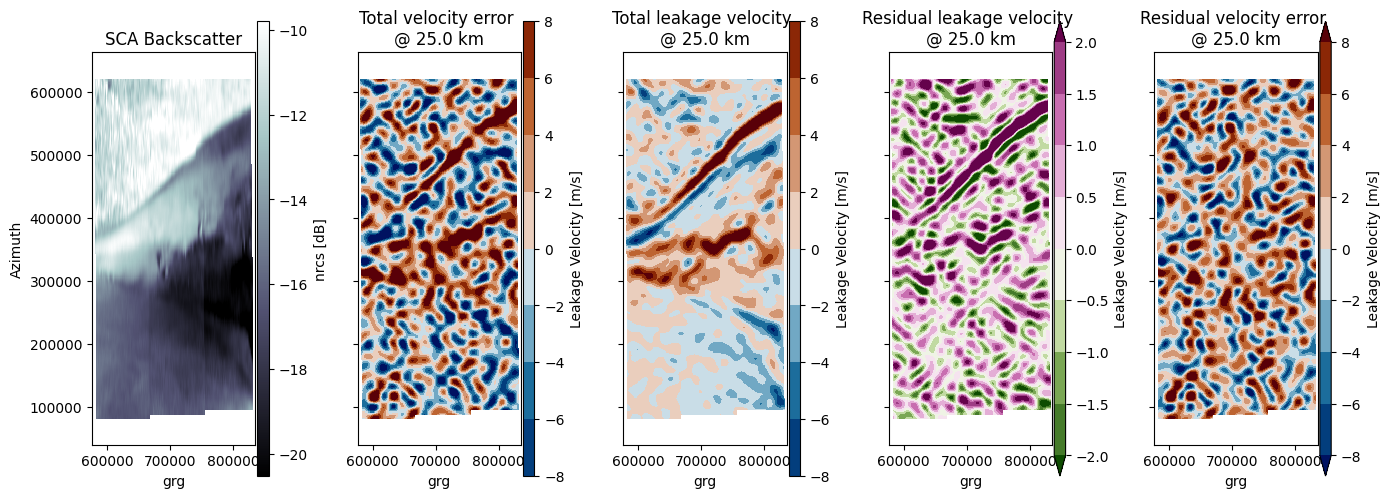

In [37]:
cbar_kwargs = {'shrink':0.8, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -8, 'vmax': 8, 'cmap' : cmc.vik, 'levels' : 9}
plot_leakage_net_kwargs = {'vmin': -2, 'vmax': 2, 'cmap' : cmc.bam_r, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 5; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (14, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

LoS_comp = 1 # (1 / np.cos(test.data['elevation_angle'].mean(dim = 'az_idx')))

plot_cut = net_velocity_error / net_velocity_error

(10*np.log10(test.data.nrcs_scat * plot_cut)).T.plot(ax= axes[*axes_indexes[0]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
# (10*np.log10(test.data.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
#                                                   **{'cmap': 'bone', **plot_kwargs},
#                                                   cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(test.data.V_sigma_subscene * plot_cut * LoS_comp).T.plot(ax= axes[*axes_indexes[1]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(test.data.V_leakage_pulse_rg_subscene * plot_cut * LoS_comp).T.plot(ax= axes[*axes_indexes[2]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_leakage  * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[3]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_velocity_error * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
# titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
titles = ['SCA Backscatter', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [19]:
func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
func_rmse(net_leakage)

1.342

In [20]:
t = test.data.V_leakage_pulse_rg.rolling(grg=test.grg_N, slow_time=test.slow_time_N, center=True).mean()

In [21]:
func_rmse(t)

2.311

In [22]:
test.velocity_error / np.sqrt(test.grg_N*test.slow_time_N)

1.3351905153842978

In [23]:
func_rmse(test.data.V_sigma_subscene * plot_cut), func_rmse(net_velocity_error)

(5.475, 4.598)

In [24]:
func_rmse(test.data.V_leakage_pulse_rg_subscene)

3.106

## Signal to Noise

In [ ]:
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
# files_dca = [file for file in files_dca if 'S1A' in file]

# add_dca_to_leakage_class(test, files_dca=files_dca)

In [ ]:
def signal_2_noise_ratio(signal, noise):
    return signal**2 / noise**2

def to_decibel(x):
    return 10*np.log10(x)

def from_decibel(x):
    return 10**(x/10)

In [ ]:
snr = to_decibel(signal_2_noise_ratio(signal=test.data.V_dca_pulse_rg_subscene, noise=net_leakage,))

-0.0816581 13.492082


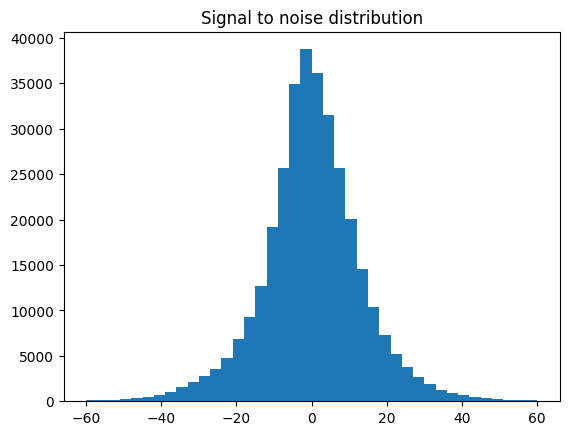

In [ ]:
_ = snr.plot.hist(bins = 40, range = (-60, 60))
plt.title('Signal to noise distribution')
print(np.nanmedian(snr), np.nanstd(snr))

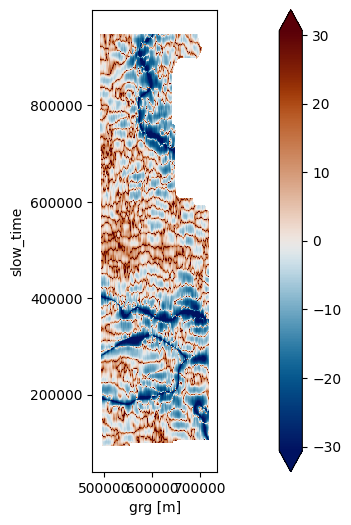

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (16, 6), sharex=True, sharey=True)
snr.T.plot(robust =True, cmap =cmc.vik, ax=axes)
axes.axes.set_aspect('equal')